<a href="https://colab.research.google.com/github/Ashwin81456/emotion-classification-using-eeg-signals/blob/main/rabin2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#import the required libraries
import os
import time
import pickle
import pandas as pd
import numpy as np
from google.colab import drive

#for feature extraction
from scipy.signal import welch
from scipy.integrate import simps

#classifier libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

import xgboost as xgb

from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

In [3]:
def read_data(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    p = x.load()
    return p

In [4]:
#creating the file names of the dataset to load it
files = []
for n in range (1, 33):
    s = 's'
    if n < 10:
        s += '0'
    s += str(n)
    s+=str(".dat")
    files.append(s)
print(files)

['s01.dat', 's02.dat', 's03.dat', 's04.dat', 's05.dat', 's06.dat', 's07.dat', 's08.dat', 's09.dat', 's10.dat', 's11.dat', 's12.dat', 's13.dat', 's14.dat', 's15.dat', 's16.dat', 's17.dat', 's18.dat', 's19.dat', 's20.dat', 's21.dat', 's22.dat', 's23.dat', 's24.dat', 's25.dat', 's26.dat', 's27.dat', 's28.dat', 's29.dat', 's30.dat', 's31.dat', 's32.dat']


In [5]:
# 32x40 = 1280 trials for 32 participants
labels = []
data = []
drive.mount('/content/drive')
for i in files:
  filename = "/content/drive/My Drive/MajorProject/Dataset/" + i
  trial = read_data(filename)
  labels.append(trial['labels'])
  data.append(trial['data'])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Lets see the shapes of the raw data
labels = np.array(labels)
data = np.array(data)
print("Labels: ", labels.shape) # participants x videos x labels
print("Data: ", data.shape) # participants x videos x channels x data

Labels:  (32, 40, 4)
Data:  (32, 40, 40, 8064)


In [7]:
# Re-shape arrays into desired shapes
labels = labels.flatten()
labels = labels.reshape(1280, 4)

data = data.flatten()
data = data.reshape(1280, 40, 8064)

In [8]:
# Double-check the new arrays
#Here trial = participants x vidoes = 32 x 40 = 1280

print("Labels: ", labels.shape) # trial x label
print("Data: ", data.shape) # trial x channel x data

Labels:  (1280, 4)
Data:  (1280, 40, 8064)


In [9]:
#creating the dataframes for the labels
labelsDf = pd.DataFrame(labels)
print("printing the labels dataframe\n")
print(labelsDf)
print("\n\nDescribing the labels dataframe")
labelsDf.describe()

printing the labels dataframe

         0     1     2     3
0     7.71  7.60  6.90  7.83
1     8.10  7.31  7.28  8.47
2     8.58  7.54  9.00  7.08
3     4.94  6.01  6.12  8.06
4     6.96  3.92  7.19  6.05
...    ...   ...   ...   ...
1275  3.91  6.96  5.82  3.12
1276  2.81  6.13  6.06  1.04
1277  3.05  7.01  5.10  1.10
1278  3.99  7.17  4.85  1.00
1279  7.15  4.03  9.00  1.88

[1280 rows x 4 columns]


Describing the labels dataframe


,0,1,2,3
count,1280.000000,1280.000000,1280.000000,1280.000000
mean,5.254313,5.156711,5.382750,5.518133
std,2.130816,2.020499,2.096321,2.282780
min,1.000000,1.000000,1.000000,1.000000
25%,3.867500,3.762500,3.932500,3.960000
50%,5.040000,5.230000,5.240000,6.050000
75%,7.050000,6.950000,7.040000,7.090000
max,9.000000,9.000000,9.000000,9.000000


In [10]:
#giving names to the label columns
df_labels= pd.DataFrame({'valence': labels[:,0], 'arousal': labels[:,1], 'dominance': labels[:,2], 'liking': labels[:,3]})
print(df_labels.describe())


           valence      arousal    dominance       liking
count  1280.000000  1280.000000  1280.000000  1280.000000
mean      5.254313     5.156711     5.382750     5.518133
std       2.130816     2.020499     2.096321     2.282780
min       1.000000     1.000000     1.000000     1.000000
25%       3.867500     3.762500     3.932500     3.960000
50%       5.040000     5.230000     5.240000     6.050000
75%       7.050000     6.950000     7.040000     7.090000
max       9.000000     9.000000     9.000000     9.000000


In [11]:
#Dropping the Dominance and Liking columns
df_labels=df_labels.drop('dominance',axis=1)
df_labels=df_labels.drop('liking',axis=1)
# print(df_labels.describe())
print(df_labels)
# df = df.drop('B', axis=1)

      valence  arousal
0        7.71     7.60
1        8.10     7.31
2        8.58     7.54
3        4.94     6.01
4        6.96     3.92
...       ...      ...
1275     3.91     6.96
1276     2.81     6.13
1277     3.05     7.01
1278     3.99     7.17
1279     7.15     4.03

[1280 rows x 2 columns]


In [12]:
# Dataset with only Valence column
df_val =labelsDf[0]
# Dataset with only Arousal column
df_aro = labelsDf[1]


In [13]:
df_aro.describe()

count    1280.000000
mean        5.156711
std         2.020499
min         1.000000
25%         3.762500
50%         5.230000
75%         6.950000
max         9.000000
Name: 1, dtype: float64

In [29]:
df_val.describe()

count    1280.000000
mean        5.254313
std         2.130816
min         1.000000
25%         3.867500
50%         5.040000
75%         7.050000
max         9.000000
Name: 0, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7ea4798e4c40>,
 'caps': [<matplotlib.lines.Line2D at 0x7ea4798e5180>,
 'boxes': [<matplotlib.patches.PathPatch at 0x7ea4798e48b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7ea4798e56c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ea4798e5960>],
 'means': []}

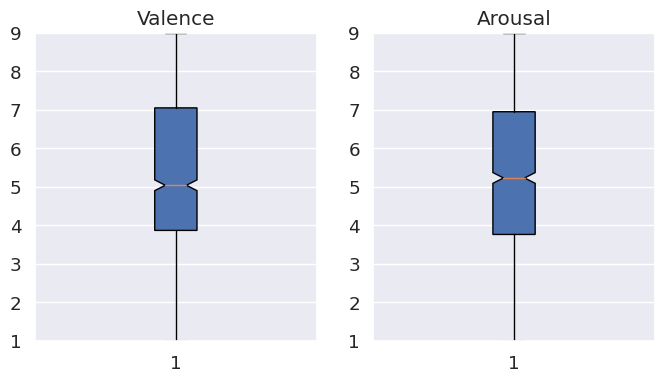

In [14]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(8,4))


axs[0].set_title("Valence")
axs[0].set_ylim(1, 9)
axs[0].boxplot(df_val,patch_artist = True,
                notch ='True')
axs[1].set_title("Arousal")
axs[1].set_ylim(1, 9)
axs[1].boxplot(df_aro,patch_artist = True,
                notch ='True')

<Axes: >

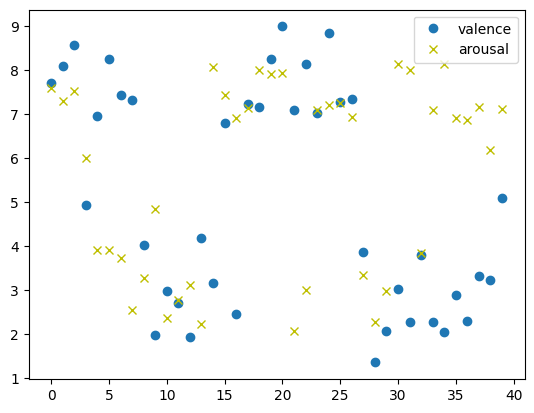

In [43]:
# Plot the first 40 data rows (first participant)
df_labels.iloc[0:40].plot(style=['o','yx'])

# Separte Valence and Arousal to HAHV, LAHV, HALV, LALV

In [15]:
import numpy as np

# # Create a sample DataFrame with 'valence' and 'arousal' columns
# np.random.seed(0)
# valence = np.random.uniform(1, 9, 1280)
# arousal = np.random.uniform(1, 9, 1280)
# data = {'valence': valence, 'arousal': arousal}
# df_valence_arousal = pd.DataFrame(data)

# Calculate the median value of arousal and valence column
arousal_median = df_labels['arousal'].median()
print(arousal_median)
valence_median = df_labels['valence'].median()
print(valence_median)

# Create a new DataFrame with the desired columns
df_result = pd.DataFrame(index=range(1280), columns=['HAHV', 'LAHV', 'HALV', 'LALV'])
df_result[['HAHV', 'LAHV', 'HALV', 'LALV']] = 0

# Apply the conditions
df_result.loc[(df_labels['valence'] >= valence_median) & (df_labels['arousal'] >= arousal_median), 'HAHV'] = 1
df_result.loc[(df_labels['arousal'] < arousal_median) & (df_labels['valence'] >= valence_median), 'LAHV'] = 1
df_result.loc[(df_labels['arousal'] >= arousal_median) & (df_labels['valence'] < valence_median), 'HALV'] = 1
df_result.loc[(df_labels['valence'] < valence_median) & (df_labels['arousal'] < arousal_median), 'LALV'] = 1

# Show the first few rows of the result DataFrame
# df_result.tail()
print(df_result)


5.23
5.04
      HAHV  LAHV  HALV  LALV
0        1     0     0     0
1        1     0     0     0
2        1     0     0     0
3        0     0     1     0
4        0     1     0     0
...    ...   ...   ...   ...
1275     0     0     1     0
1276     0     0     1     0
1277     0     0     1     0
1278     0     0     1     0
1279     0     1     0     0

[1280 rows x 4 columns]


Verify the data in 4 classes

In [16]:
# Check the number of 1s in each individual column
count_HAHV = df_result['HAHV'].sum()
count_LAHV = df_result['LAHV'].sum()
count_HALV = df_result['HALV'].sum()
count_LALV = df_result['LALV'].sum()

print(f"Number of 1s in HAHV: {count_HAHV}")
print(f"Number of 1s in LAHV: {count_LAHV}")
print(f"Number of 1s in HALV: {count_HALV}")
print(f"Number of 1s in LALV: {count_LALV}")

print(f"Total = {count_HAHV+count_LAHV+count_HALV+count_LALV}") # the total must be 1280


Number of 1s in HAHV: 358
Number of 1s in LAHV: 322
Number of 1s in HALV: 282
Number of 1s in LALV: 318
Total = 1280


In [17]:
# Dataset with only Valence column
df_val = df_labels['valence']
# Dataset with only Arousal column
df_aro = df_labels['arousal']

In [18]:
# Function to check if each trial has positive or negative valence
def positive_valence(trial):
    return 1 if labels[trial,0] >= np.median(labels[:,0]) else 0
# Function to check if each trial has high or low arousal
def high_arousal(trial):
    return 1 if labels[trial,1] >= np.median(labels[:,1]) else 0

In [19]:
# Convert all ratings to boolean values
labels_encoded = []
for i in range (len(labels)):
    labels_encoded.append([positive_valence(i), high_arousal(i)])
labels_encoded = np.reshape(labels_encoded, (1280, 2))
df_labels = pd.DataFrame(data=labels_encoded, columns=["High Valence", "High Arousal"])
print(df_labels.describe())
print(df_labels)

       High Valence  High Arousal
count   1280.000000   1280.000000
mean       0.531250      0.500000
std        0.499218      0.500195
min        0.000000      0.000000
25%        0.000000      0.000000
50%        1.000000      0.500000
75%        1.000000      1.000000
max        1.000000      1.000000
      High Valence  High Arousal
0                1             1
1                1             1
2                1             1
3                0             1
4                1             0
...            ...           ...
1275             0             1
1276             0             1
1277             0             1
1278             0             1
1279             1             0

[1280 rows x 2 columns]


In [20]:
# Dataset with only Valence column
df_valence = df_labels['High Valence']
# Dataset with only Arousal column
df_arousal = df_labels['High Arousal']
print(df_valence)
print(df_valence.shape)

0       1
1       1
2       1
3       0
4       1
       ..
1275    0
1276    0
1277    0
1278    0
1279    1
Name: High Valence, Length: 1280, dtype: int64
(1280,)


# FEATURE EXTRACTION USING WELCH'S METHOD

In [21]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
peripheral_channels = np.array(["hEOG", "vEOG", "zEMG", "tEMG", "GSR", "Respiration belt", "Plethysmograph", "Temperature"])

In [22]:
eeg_data = []
for i in range (len(data)):
  for j in range (len(eeg_channels)):
    eeg_data.append(data[i,j])
eeg_data = np.reshape(eeg_data, (len(data), len(eeg_channels), len(data[0,0])))
print(eeg_data.shape)

(1280, 32, 8064)


In [23]:
peripheral_data = []
for i in range (len(data)):
  for j in range (32,len(data[0])):
    peripheral_data.append(data[i,j])
peripheral_data = np.reshape(peripheral_data, (len(data), len(peripheral_channels), len(data[0,0])))
print(peripheral_data.shape)

(1280, 8, 8064)


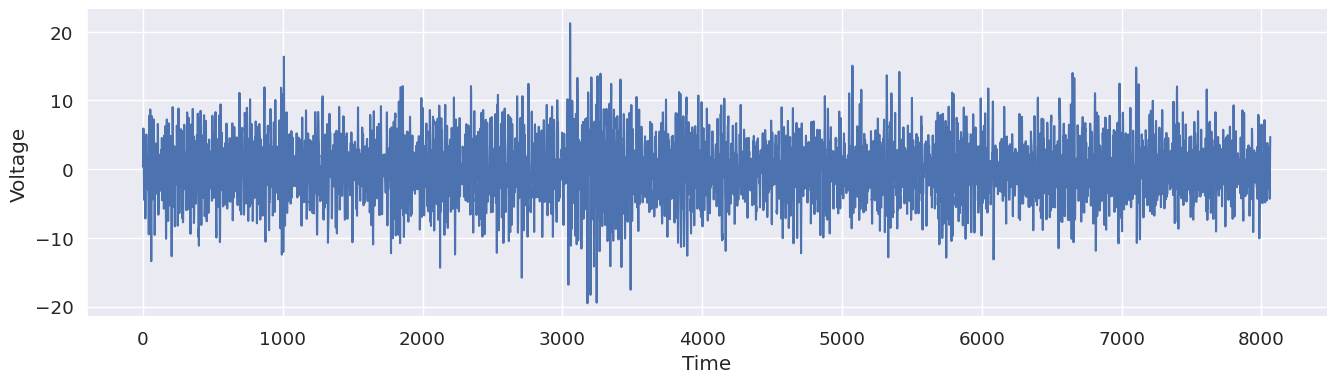

In [24]:
import seaborn as sns
sns.set(font_scale=1.2)
# Define sampling frequency and time vector
sf = 128.
time = np.arange(eeg_data.size) / sf

# Plot the signal of first trial, last channel
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(eeg_data[0,31], lw=1.5, color='b')
plt.xlabel('Time')
plt.ylabel('Voltage')
sns.despine()

In [49]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [50]:
def get_band_power(trial, channel, band):
  bd = (0,0)

  if (band == "theta"): # drownsiness, emotional connection, intuition, creativity
    bd = (4,8)
  elif (band == "alpha"): # reflection, relaxation
    bd = (8,12)
  elif (band == "beta"): # concentration, problem solving, memory
    bd = (12,30)
  elif (band == "gamma"): # cognition, perception, learning, multi-tasking
    bd = (30,64)

  return bandpower(eeg_data[trial,channel], 128, bd)


In [51]:
print(get_band_power(0,31,"theta"))
print(get_band_power(0,31,"alpha"))
print(get_band_power(0,31,"beta"))
print(get_band_power(0,31,"gamma"))

5.434119660168186
5.369595513295193
6.286556266834863
0.9879159580139809


# Process new datasets with 6 EEG regions and 4 band power values

In [52]:
# Transform 1280x 32 x 8064 => 1280 x 128
eeg_band_arr = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_band_arr.append(get_band_power(i,j,"theta"))
    eeg_band_arr.append(get_band_power(i,j,"alpha"))
    eeg_band_arr.append(get_band_power(i,j,"beta"))
    eeg_band_arr.append(get_band_power(i,j,"gamma"))
eeg_band_arr = np.reshape(eeg_band_arr, (1280, 128))

KeyboardInterrupt: 

In [ ]:
frontal = np.array(["F3", "FC1", "Fz", "F4", "FC2"])
parietal = np.array(["P3", "P7", "Pz", "P4", "P8"])
occipital = np.array(["O1", "Oz", "O2", "PO3", "PO4"])
central = np.array(["CP5", "CP1", "Cz", "C4", "C3", "CP6", "CP2"])

In [ ]:
eeg_theta = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_theta.append(get_band_power(i,j,"theta"))
eeg_theta = np.reshape(eeg_theta, (1280, 32))

df_theta = pd.DataFrame(data = eeg_theta, columns=eeg_channels)
print(df_theta.describe())

In [ ]:
# Transform 880 x 32 x 8064 => 880 x 32
eeg_alpha = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_alpha.append(get_band_power(i,j,"alpha"))
eeg_alpha = np.reshape(eeg_alpha, (1280, 32))

df_alpha = pd.DataFrame(data = eeg_alpha, columns=eeg_channels)
print(df_alpha.describe())

In [ ]:
# Transform 880 x 32 x 8064 => 880 x 32
eeg_beta = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_beta.append(get_band_power(i,j,"beta"))
eeg_beta = np.reshape(eeg_beta, (1280, 32))

df_beta = pd.DataFrame(data = eeg_beta, columns=eeg_channels)
print(df_beta.describe())

In [ ]:
# Transform 880 x 32 x 8064 => 880 x 32
eeg_gamma = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_gamma.append(get_band_power(i,j,"gamma"))
eeg_gamma = np.reshape(eeg_gamma, (1280, 32))

df_gamma = pd.DataFrame(data = eeg_gamma, columns=eeg_channels)
print(df_gamma.describe())

In [ ]:
# Split the data into training/testing sets
def split_train_test(x, y):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
  return x_train, x_test, y_train, y_test

In [ ]:
# Feature scaling
def feature_scaling(train, test):
  sc = StandardScaler()
  train = sc.fit_transform(train)
  test = sc.transform(test)
  return train, test

In [ ]:
band_names = np.array(["theta", "alpha", "beta", "gamma"])
channel_names = np.array(["frontal",  "central", "parietal", "occipital"])
label_names = np.array(["valence", "arousal"])

In [ ]:
# Testing different kernels (linear, sigmoid, rbf, poly) to select the most optimal one
clf_svm = SVC(kernel = 'rbf',random_state = 42, probability=True)

In [ ]:
# Testing different k (odd) numbers, algorithm (auto, ball_tree, kd_tree) and weight (uniform, distance) to select the most optimal one
clf_knn = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto')

In [ ]:
clf_dtree=DecisionTreeClassifier(max_depth=20,min_samples_split=4)

In [ ]:
clf_rf=RandomForestClassifier(n_estimators=50,max_depth=20,min_samples_split=5)

In [ ]:
clf_nb= GaussianNB()

In [ ]:
# Testing different learning rate (alpha), solver (adam, sgd, lbfgs) and activation (relu, tanh, logistic) to select the most optimal one
clf_mlp = MLPClassifier(solver='adam', activation='tanh', alpha=0.3, max_iter=400)

In [ ]:
clf_adaboost = AdaBoostClassifier(n_estimators=50, random_state=42)


In [ ]:
clf_xgb = xgb.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, random_state=42)


In [ ]:
import lightgbm as lgb
clf_lgbm = lgb.LGBMClassifier()

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
clf_gpc = GaussianProcessClassifier(kernel=1.0 * RBF(length_scale=1.0), random_state=42)


In [ ]:
from sklearn.linear_model import Perceptron
clf_perceptron = Perceptron(random_state=42)

In [ ]:
!pip install catboost
import catboost as cb
clf_catboost = cb.CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, loss_function='Logloss', verbose=0)


In [ ]:
#define cnn model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input

def create_cnn_model(data_np):
    model = Sequential([
        Input(shape=(data_np.shape[1], 1)),  # Adjusted to match data_np shape
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(2, activation='softmax')
    ])
    return model

def train_and_evaluate_cnn(df_x, df_y):
    # Convert dataframes to numpy arrays
    data_np = df_x.values
    labels_np = df_y.values

    # Reshape data for CNN: (number of samples, height, width, channels)
    # Here, height=1, width=number of features, channels=1
    data_reshaped = data_np.reshape((data_np.shape[0], data_np.shape[1], 1))

    # One-hot encode the labels
    labels_encoded = to_categorical(labels_np)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_reshaped, labels_encoded, test_size=0.20, random_state=42)

    # Define the CNN model
    model = create_cnn_model(data_np)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    return test_loss, test_accuracy


In [ ]:
#define ann model
def create_ann_model(data_scaled):
    model = Sequential([
        Dense(64, input_dim=data_scaled.shape[1], activation='relu'),
        Dense(64, activation='relu'),
        Dense(2, activation='softmax')  # Assuming two classes: 0 and 1
    ])
    return model


def train_and_evaluate_ann(df_x, df_y):
    # Convert dataframes to numpy arrays
    data_np = df_x.values
    labels_np = df_y.values

    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_np)

    # One-hot encode the labels
    labels_encoded = to_categorical(labels_np)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_scaled, labels_encoded, test_size=0.2, random_state=42)

    # Define the CNN model
    model = create_ann_model(data_np)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    return test_loss, test_accuracy

In [ ]:
#define lstm model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical


def create_lstm_model(data_np):
    model = Sequential([
    LSTM(20, input_shape=(data_np.shape[1], 1)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Assuming two classes: 0 and 1
    ])
    return model

def train_and_evaluate_lstm(df_x, df_y):
    # Convert dataframes to numpy arrays
    data_np = df_x.values
    labels_np = df_y.values

    # Reshape data for LSTM: (samples, time_steps, features)
    # Here, each row is treated as a sequence with a single time step
    data_reshaped = data_np.reshape((data_np.shape[0], data_np.shape[1], 1))

    # One-hot encode the labels
    labels_encoded = to_categorical(labels_np)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_reshaped, labels_encoded, test_size=0.2, random_state=42)
    # Define the CNN model
    model = create_lstm_model(data_np)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    return test_loss, test_accuracy




In [ ]:
models = []
models.append(('SVM', clf_svm))
models.append(('k-NN', clf_knn))
models.append(('DT', clf_dtree))
models.append(('RF', clf_rf))
models.append(('NB', clf_nb))
models.append(('MLP', clf_mlp))
models.append(('AB', clf_adaboost))
models.append(('XGB', clf_xgb))

In [ ]:
def run_clf_cv(band, channel, label, clf):
  if (band == "theta"):
    df_x = df_theta
  elif (band == "alpha"):
    df_x = df_alpha
  elif (band == "beta"):
    df_x = df_beta
  elif (band == "gamma"):
    df_x = df_gamma

  if (channel == "frontal"):
    df_x = df_x[frontal]
  elif (channel == "central"):
    df_x = df_x[central]
  elif (channel == "parietal"):
    df_x = df_x[parietal]
  elif (channel == "occipital"):
    df_x = df_x[occipital]

  # df_y = df_arousal if (label == "arousal") else df_valence
  # print(df_y.shape)
  # df_y = df_result["HAHV"]
  # df_y = df_result
  # df_y = df_y.flatten
  # print(f"the shape of df_y is {df_y.shape}")
  # print(f"the shape of df_x is {df_x.shape}")
  if (label == "HAHV"):
    df_y = df_result["HAHV"]
  elif (label == "LAHV"):
    df_y = df_result["LAHV"]
  elif (label == "HALV"):
    df_y = df_result["HALV"]
  elif (label == "LALV"):
    df_y = df_result["LALV"]

  # print(f"the shape of df_y is {df_y.shape}")
  # print(f"the shape of df_x is {df_x.shape}")
  # Train-test split

  # save he dataframes in csv format for analysis
  # if (band == "gamma" and channel == "frontal" and label == "HALV"):
  #   df_y.to_csv('labels.csv', index=False)
  #   print("DataFrame saved to 'labels.csv'")
  #   df_x.to_csv('data.csv', index=False)
  #   print("DataFrame saved to 'data.csv'")
  #   from google.colab import files
  #   files.download('labels.csv')
  #   files.download('data.csv')

  x_train, x_test, y_train, y_test = split_train_test(df_x, df_y)

  # Apply CV
  x_for_kfold = np.array(x_train)
  y_for_kfold = np.array(y_train)
  kfold = model_selection.KFold(n_splits=5)

  for i, j in kfold.split(x_for_kfold):
   x_train2, x_test2 = x_for_kfold[i], x_for_kfold[j]
   y_train2, y_test2 = y_for_kfold[i], y_for_kfold[j]

  # Feature scaling
  x_train2, x_test2 = feature_scaling(x_train2, x_test2)

  # Feature scaling
  # scaler = StandardScaler()
  # x_train2 = scaler.fit_transform(x_train2)
  # x_test2 = scaler.transform(x_test2)


  if (clf == "svm"):
    clf_svm.fit(x_train2, y_train2)
    y_predict = clf_svm.predict(x_test2)
  elif (clf == "knn"):
    clf_knn.fit(x_train2, y_train2)
    y_predict = clf_knn.predict(x_test2)
  elif (clf == "dtree"):
    clf_dtree.fit(x_train2, y_train2)
    y_predict = clf_dtree.predict(x_test2)
  elif (clf == "rf"):
    clf_rf.fit(x_train2, y_train2)
    y_predict = clf_rf.predict(x_test2)
  elif (clf == "nb"):
    clf_nb.fit(x_train2, y_train2)
    y_predict = clf_nb.predict(x_test2)
  elif (clf == "mlp"):
    clf_mlp.fit(x_train2, y_train2)
    y_predict = clf_mlp.predict(x_test2)
  elif (clf == "ab"):
    clf_adaboost.fit(x_train2, y_train2)
    y_predict = clf_adaboost.predict(x_test2)
  elif (clf == "xgb"):
    clf_xgb.fit(x_train2, y_train2)
    y_predict = clf_xgb.predict(x_test2)
  elif (clf == "lgbm"):
    clf_lgbm.fit(x_train2, y_train2)
    y_predict = clf_lgbm.predict(x_test2)
  elif (clf == "gpc"):
    clf_gpc.fit(x_train2, y_train2)
    y_predict = clf_gpc.predict(x_test2)
  elif (clf == "per"):
    clf_perceptron.fit(x_train2, y_train2)
    y_predict = clf_perceptron.predict(x_test2)
  elif (clf == "cb"):
    clf_catboost.fit(x_train2, y_train2)
    y_predict = clf_catboost.predict(x_test2)
  elif (clf == "cnn"):
    # Evaluate the model on the test set
    test_loss, test_accuracy = train_and_evaluate_cnn(df_x, df_y)
    # print(f"Test Loss: {test_loss}")
    # print(f"Test Accuracy: {test_accuracy}")
    return "DL",test_loss, test_accuracy

  elif(clf =="ann"):
    test_loss, test_accuracy = train_and_evaluate_ann(df_x, df_y)
    # print(f"Test Loss: {test_loss}")
    # print(f"Test Accuracy: {test_accuracy}")
    return "DL",test_loss, test_accuracy
  elif(clf =="lstm"):
    test_loss, test_accuracy = train_and_evaluate_lstm(df_x, df_y)
    return "DL",test_loss,test_accuracy
  return "ML",y_test2, y_predict

In [ ]:
def get_accuracy(band, channel, label, clf):
  classifier,y_test2, y_predict = run_clf_cv(band, channel, label, clf)
  if (classifier == "DL"):
    return y_predict
  return np.round(accuracy_score(y_test2, y_predict)*100,2)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
def print_conf(band, channel, label, clf):
  y_test2, y_predict = run_clf_cv(band, channel, label, clf)
  conf_matrix = confusion_matrix(y_test2, y_predict)
  # print(conf_matrix)
  plt.figure(figsize=(4, 2))  # Decrease the figure size
  plt.title('Confusion Matrix')
  sns.heatmap(conf_matrix,
              annot=True,
              fmt='g',
              xticklabels=['Not Spam','Spam'],
              yticklabels=['Not Spam','Spam'])

  # display matrix
  plt.ylabel('Actual',fontsize=12)
  plt.xlabel('Prediction',fontsize=12)
  plt.show()

  # printing the classification report aswell

  class_report = classification_report(y_test2, y_predict, target_names=['Not Spam', 'Spam'])
  print("\nClassification Report:")
  print(class_report)

In [ ]:
def print_accuracy(label, clf):
  arr = []
  for i in range (len(band_names)):
    for j in range (len(channel_names)):
      arr.append(get_accuracy(band_names[i], channel_names[j], label, clf))
  arr = np.reshape(arr, (4,4))
  df = pd.DataFrame(data = arr, index=band_names, columns=channel_names)

  #print("Top 3 EEG regions with highest scores")
  #print(df.apply(lambda s: s.abs()).max().nlargest(3))
  #print()
  #print("Top 2 bands with highest scores")
  #print(df.apply(lambda s: s.abs()).max(axis=1).nlargest(2))
  #print()
  #print("EEG region with highest scores per each band")
  #print(df.idxmax(axis=1))
  #print()
  #print("Accuracy Scores")
  #print(df.idxmax())
  #print()
  print(df)

In [ ]:
print_accuracy('HAHV', 'svm')

In [ ]:
print_conf("beta","frontal","HAHV","svm")

In [ ]:
print_accuracy('LAHV', 'svm')

In [ ]:
print_conf("theta","occipital","LAHV","svm")

In [ ]:
print_accuracy('HALV', 'svm')

In [ ]:
print_conf("gamma","frontal","HALV","svm")

In [ ]:
print_accuracy('LALV', 'svm')

In [ ]:
print_conf("gamma","occipital","LALV","svm")

In [ ]:
print_accuracy("LALV","ann")

In [ ]:
print_accuracy("HALV","lstm")

In [ ]:
# print the confusion matrix which gives the highest accuracy
print_conf("theta","parietal","arousal","svm")

In [ ]:
print_accuracy('valence', 'svm')

In [ ]:
print_conf("gamma","central","valence","svm")

In [ ]:
print_accuracy('HAHV', 'ab')

In [ ]:
print_conf("gamma","occipital","arousal","ab")

In [ ]:
print_accuracy('valence', 'ab')

In [ ]:
print_accuracy('HAHV', 'xgb')

In [ ]:
print_accuracy('valence', 'xgb')

In [ ]:
print_conf("beta","central","valence","xgb")

In [ ]:
print_accuracy('HAHV', 'knn')

In [ ]:
print_accuracy('LALV', 'knn')

In [ ]:
print_accuracy('HALV', 'knn')

In [ ]:
print_accuracy('LAHV', 'knn')

In [ ]:
print_accuracy('HAHV', 'dtree')

In [ ]:
print_accuracy('LALV', 'dtree')

In [ ]:
print_accuracy('HAHV', 'rf')

In [ ]:
print_accuracy('LAHV', 'rf')

In [ ]:
print_accuracy('HALV', 'rf')

In [ ]:
print_accuracy('LALV', 'rf')

In [ ]:
print_accuracy('HAHV', 'cnn')

In [ ]:
print_accuracy('HALV', 'cnn')

In [ ]:
print_accuracy('valence', 'nb')

In [ ]:
print_accuracy('arousal', 'mlp')

In [ ]:
print_accuracy('valence', 'mlp')

In [ ]:
print_accuracy('arousal', 'lgbm')

In [ ]:
print_accuracy('valence', 'lgbm')

In [ ]:
print_accuracy('arousal', 'gpc')

In [ ]:
print_accuracy('valence', 'gpc')

In [ ]:
print_accuracy('arousal', 'per')

In [ ]:
print_accuracy('valence', 'per')

In [ ]:
print_accuracy('arousal', 'cb')

In [ ]:
print_conf("gamma","frontal","arousal","cb")

In [ ]:
print_accuracy('HAHV', 'cb')